In [17]:
import os
import glob
import time
import numpy as np
from PIL import Image
from pathlib import Path
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
from skimage.color import rgb2lab, lab2rgb

import torch
from torch import nn, optim
from torchvision import transforms
from torchvision.utils import make_grid
from torch.utils.data import Dataset, DataLoader
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
use_colab = None

In [18]:
base_path = '/kaggle/input/pascal-voc-2012-dataset/VOC2012_train_val/VOC2012_train_val/JPEGImages'

from sklearn.model_selection import train_test_split

all_image_paths = sorted([os.path.join(base_path, img) for img in os.listdir(base_path) if img.endswith('.jpg')])

image_paths = all_image_paths[:10000]

train_paths, val_paths = train_test_split(image_paths, test_size=0.2, random_state=42)


In [19]:
SIZE = 256
class ColorizationDataset(Dataset):
    def __init__(self, paths, split='train'):
        if split == 'train':
            self.transforms = transforms.Compose([
                transforms.Resize((SIZE, SIZE),  Image.BICUBIC),
                transforms.RandomHorizontalFlip(), # A little data augmentation!
            ])
        elif split == 'val':
            self.transforms = transforms.Resize((SIZE, SIZE),  Image.BICUBIC)
        
        self.split = split
        self.size = SIZE
        self.paths = paths
    
    def __getitem__(self, idx):
        img = Image.open(self.paths[idx]).convert("RGB")
        img = self.transforms(img)
        img = np.array(img)
        img_lab = rgb2lab(img).astype("float32") # Converting RGB to L*a*b
        img_lab = transforms.ToTensor()(img_lab)
        L = img_lab[[0], ...] / 50. - 1. # Between -1 and 1
        ab = img_lab[[1, 2], ...] / 110. # Between -1 and 1
        
        return {'L': L, 'ab': ab}
    
    def __len__(self):
        return len(self.paths)

def make_dataloaders(batch_size=16, n_workers=4, pin_memory=True, **kwargs): # A handy function to make our dataloaders
    dataset = ColorizationDataset(**kwargs)
    dataloader = DataLoader(dataset, batch_size=batch_size, num_workers=n_workers,
                            pin_memory=pin_memory)
    return dataloader

In [20]:
train_dl = make_dataloaders(paths=train_paths, split='train')
val_dl = make_dataloaders(paths=val_paths, split='val')

data = next(iter(train_dl))
Ls, abs_ = data['L'], data['ab']
print(Ls.shape, abs_.shape)
print(len(train_dl), len(val_dl))

torch.Size([16, 1, 256, 256]) torch.Size([16, 2, 256, 256])
500 125


In [21]:
class UnetBlock(nn.Module):
    def __init__(self, nf, ni, submodule=None, input_c=None, dropout=False,
                 innermost=False, outermost=False):
        super().__init__()
        self.outermost = outermost
        if input_c is None: input_c = nf
        downconv = nn.Conv2d(input_c, ni, kernel_size=4,
                             stride=2, padding=1, bias=False)
        downrelu = nn.LeakyReLU(0.2, True)
        downnorm = nn.BatchNorm2d(ni)
        uprelu = nn.ReLU(True)
        upnorm = nn.BatchNorm2d(nf)
        
        if outermost:
            upconv = nn.ConvTranspose2d(ni * 2, nf, kernel_size=4,
                                        stride=2, padding=1)
            down = [downconv]
            up = [uprelu, upconv, nn.Tanh()]
            model = down + [submodule] + up
        elif innermost:
            upconv = nn.ConvTranspose2d(ni, nf, kernel_size=4,
                                        stride=2, padding=1, bias=False)
            down = [downrelu, downconv]
            up = [uprelu, upconv, upnorm]
            model = down + up
        else:
            upconv = nn.ConvTranspose2d(ni * 2, nf, kernel_size=4,
                                        stride=2, padding=1, bias=False)
            down = [downrelu, downconv, downnorm]
            up = [uprelu, upconv, upnorm]
            if dropout: up += [nn.Dropout(0.5)]
            model = down + [submodule] + up
        self.model = nn.Sequential(*model)
    
    def forward(self, x):
        if self.outermost:
            return self.model(x)
        else:
            return torch.cat([x, self.model(x)], 1)

class Unet(nn.Module):
    def __init__(self, input_c=1, output_c=2, n_down=8, num_filters=64):
        super().__init__()
        unet_block = UnetBlock(num_filters * 8, num_filters * 8, innermost=True)
        for _ in range(n_down - 5):
            unet_block = UnetBlock(num_filters * 8, num_filters * 8, submodule=unet_block, dropout=True)
        out_filters = num_filters * 8
        for _ in range(3):
            unet_block = UnetBlock(out_filters // 2, out_filters, submodule=unet_block)
            out_filters //= 2
        self.model = UnetBlock(output_c, out_filters, input_c=input_c, submodule=unet_block, outermost=True)
    
    def forward(self, x):
        return self.model(x)

In [22]:
class PatchDiscriminator(nn.Module):
    def __init__(self, input_c, num_filters=64, n_down=3):
        super().__init__()
        model = [self.get_layers(input_c, num_filters, norm=False)]
        model += [self.get_layers(num_filters * 2 ** i, num_filters * 2 ** (i + 1), s=1 if i == (n_down-1) else 2) 
                          for i in range(n_down)] # the 'if' statement is taking care of not using
                                                  # stride of 2 for the last block in this loop
        model += [self.get_layers(num_filters * 2 ** n_down, 1, s=1, norm=False, act=False)] # Make sure to not use normalization or
                                                                                             # activation for the last layer of the model
        self.model = nn.Sequential(*model)                                                   
        
    def get_layers(self, ni, nf, k=4, s=2, p=1, norm=True, act=True): # when needing to make some repeatitive blocks of layers,
        layers = [nn.Conv2d(ni, nf, k, s, p, bias=not norm)]          # it's always helpful to make a separate method for that purpose
        if norm: layers += [nn.BatchNorm2d(nf)]
        if act: layers += [nn.LeakyReLU(0.2, True)]
        return nn.Sequential(*layers)
    
    def forward(self, x):
        return self.model(x)

In [23]:
discriminator = PatchDiscriminator(3)
dummy_input = torch.randn(16, 3, 256, 256) # batch_size, channels, size, size
out = discriminator(dummy_input)
out.shape

torch.Size([16, 1, 30, 30])

In [24]:
class GANLoss(nn.Module):
    def __init__(self, gan_mode='vanilla', real_label=1.0, fake_label=0.0):
        super().__init__()
        self.register_buffer('real_label', torch.tensor(real_label))
        self.register_buffer('fake_label', torch.tensor(fake_label))
        if gan_mode == 'vanilla':
            self.loss = nn.BCEWithLogitsLoss()
        elif gan_mode == 'lsgan':
            self.loss = nn.MSELoss()
    
    def get_labels(self, preds, target_is_real):
        if target_is_real:
            labels = self.real_label
        else:
            labels = self.fake_label
        return labels.expand_as(preds)
    
    def __call__(self, preds, target_is_real):
        labels = self.get_labels(preds, target_is_real)
        loss = self.loss(preds, labels)
        return loss

In [25]:
def init_weights(net, init='norm', gain=0.02):
    
    def init_func(m):
        classname = m.__class__.__name__
        if hasattr(m, 'weight') and 'Conv' in classname:
            if init == 'norm':
                nn.init.normal_(m.weight.data, mean=0.0, std=gain)
            elif init == 'xavier':
                nn.init.xavier_normal_(m.weight.data, gain=gain)
            elif init == 'kaiming':
                nn.init.kaiming_normal_(m.weight.data, a=0, mode='fan_in')
            
            if hasattr(m, 'bias') and m.bias is not None:
                nn.init.constant_(m.bias.data, 0.0)
        elif 'BatchNorm2d' in classname:
            nn.init.normal_(m.weight.data, 1., gain)
            nn.init.constant_(m.bias.data, 0.)
            
    net.apply(init_func)
    print(f"model initialized with {init} initialization")
    return net

def init_model(model, device):
    model = model.to(device)
    model = init_weights(model)
    return model

In [26]:
class MainModel(nn.Module):
    def __init__(self, net_G=None, lr_G=2e-4, lr_D=2e-4, 
                 beta1=0.5, beta2=0.999, lambda_L1=100.):
        super().__init__()
        
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.lambda_L1 = lambda_L1
        
        if net_G is None:
            self.net_G = init_model(Unet(input_c=1, output_c=2, n_down=8, num_filters=64), self.device)
        else:
            self.net_G = net_G.to(self.device)
        self.net_D = init_model(PatchDiscriminator(input_c=3, n_down=3, num_filters=64), self.device)
        self.GANcriterion = GANLoss(gan_mode='vanilla').to(self.device)
        self.L1criterion = nn.L1Loss()
        self.opt_G = optim.Adam(self.net_G.parameters(), lr=lr_G, betas=(beta1, beta2))
        self.opt_D = optim.Adam(self.net_D.parameters(), lr=lr_D, betas=(beta1, beta2))
    
    def set_requires_grad(self, model, requires_grad=True):
        for p in model.parameters():
            p.requires_grad = requires_grad
        
    def setup_input(self, data):
        self.L = data['L'].to(self.device)
        self.ab = data['ab'].to(self.device)
        
    def forward(self):
        self.fake_color = self.net_G(self.L)
    
    def backward_D(self):
        fake_image = torch.cat([self.L, self.fake_color], dim=1)
        fake_preds = self.net_D(fake_image.detach())
        self.loss_D_fake = self.GANcriterion(fake_preds, False)
        real_image = torch.cat([self.L, self.ab], dim=1)
        real_preds = self.net_D(real_image)
        self.loss_D_real = self.GANcriterion(real_preds, True)
        self.loss_D = (self.loss_D_fake + self.loss_D_real) * 0.5
        self.loss_D.backward()
    
    def backward_G(self):
        fake_image = torch.cat([self.L, self.fake_color], dim=1)
        fake_preds = self.net_D(fake_image)
        self.loss_G_GAN = self.GANcriterion(fake_preds, True)
        self.loss_G_L1 = self.L1criterion(self.fake_color, self.ab) * self.lambda_L1
        self.loss_G = self.loss_G_GAN + self.loss_G_L1
        self.loss_G.backward()
    
    def optimize(self):
        self.forward()
        self.net_D.train()
        self.set_requires_grad(self.net_D, True)
        self.opt_D.zero_grad()
        self.backward_D()
        self.opt_D.step()
        
        self.net_G.train()
        self.set_requires_grad(self.net_D, False)
        self.opt_G.zero_grad()
        self.backward_G()
        self.opt_G.step()

In [27]:
class AverageMeter:
    def __init__(self):
        self.reset()
        
    def reset(self):
        self.count, self.avg, self.sum = [0.] * 3
    
    def update(self, val, count=1):
        self.count += count
        self.sum += count * val
        self.avg = self.sum / self.count

def create_loss_meters():
    loss_D_fake = AverageMeter()
    loss_D_real = AverageMeter()
    loss_D = AverageMeter()
    loss_G_GAN = AverageMeter()
    loss_G_L1 = AverageMeter()
    loss_G = AverageMeter()
    
    return {'loss_D_fake': loss_D_fake,
            'loss_D_real': loss_D_real,
            'loss_D': loss_D,
            'loss_G_GAN': loss_G_GAN,
            'loss_G_L1': loss_G_L1,
            'loss_G': loss_G}

def update_losses(model, loss_meter_dict, count):
    for loss_name, loss_meter in loss_meter_dict.items():
        loss = getattr(model, loss_name)
        loss_meter.update(loss.item(), count=count)

def lab_to_rgb(L, ab):
    """
    Takes a batch of images
    """
    
    L = (L + 1.) * 50.
    ab = ab * 110.
    Lab = torch.cat([L, ab], dim=1).permute(0, 2, 3, 1).cpu().numpy()
    rgb_imgs = []
    for img in Lab:
        img_rgb = lab2rgb(img)
        rgb_imgs.append(img_rgb)
    return np.stack(rgb_imgs, axis=0)
    
def visualize(model, data, save=True):
    model.net_G.eval()
    with torch.no_grad():
        model.setup_input(data)
        model.forward()
    model.net_G.train()
    fake_color = model.fake_color.detach()
    real_color = model.ab
    L = model.L
    fake_imgs = lab_to_rgb(L, fake_color)
    real_imgs = lab_to_rgb(L, real_color)
    fig = plt.figure(figsize=(15, 8))
    for i in range(5):
        ax = plt.subplot(3, 5, i + 1)
        ax.imshow(L[i][0].cpu(), cmap='gray')
        ax.axis("off")
        ax = plt.subplot(3, 5, i + 1 + 5)
        ax.imshow(fake_imgs[i])
        ax.axis("off")
        ax = plt.subplot(3, 5, i + 1 + 10)
        ax.imshow(real_imgs[i])
        ax.axis("off")
    plt.show()
    if save:
        fig.savefig(f"colorization_{time.time()}.png")
        
def log_results(loss_meter_dict):
    for loss_name, loss_meter in loss_meter_dict.items():
        print(f"{loss_name}: {loss_meter.avg:.5f}")

In [28]:
from fastai.vision.learner import create_body
from torchvision.models import mobilenet_v2
from fastai.vision.models.unet import DynamicUnet

In [29]:
from fastai.vision.all import *
from torchvision.models import mobilenet_v2

def build_mobilenet_unet(n_input=1, n_output=2, size=256):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    
    # Initialize mobilenet_v2
    mobilenet = mobilenet_v2(pretrained=True)
    
    # Create the body with the first layer adjusted for the specified `n_input`
    body = create_body(mobilenet.features, pretrained=True, n_in=n_input, cut=-2)
    
    # Create the Dynamic Unet with the mobilenet body
    net_G = DynamicUnet(body, n_output, (size, size)).to(device)
    return net_G

In [30]:
def pretrain_generator(net_G, train_dl, opt, criterion, epochs):
    for e in range(epochs):
        loss_meter = AverageMeter()
        for data in tqdm(train_dl):
            L, ab = data['L'].to(device), data['ab'].to(device)
            preds = net_G(L)
            loss = criterion(preds, ab)
            opt.zero_grad()
            loss.backward()
            opt.step()
            
            loss_meter.update(loss.item(), L.size(0))
            
        print(f"Epoch {e + 1}/{epochs}")
        print(f"L1 Loss: {loss_meter.avg:.5f}")

In [31]:
generator_model_path = '/kaggle/input/mobilenet50/pytorch/default/1/mobile-unet_gen_50.pt'
colorization_model_path = '/kaggle/input/mobilenet50/pytorch/default/1/pascal_final_model_mobile50.pt'

In [32]:
net_G = build_mobilenet_unet(n_input=1, n_output=2, size=256)
net_G.load_state_dict(torch.load(generator_model_path, map_location=device))
model = MainModel(net_G=net_G)
model.load_state_dict(torch.load(colorization_model_path, map_location=device))

/tmp/ipykernel_30/3581983077.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  net_G.load_state_dict(torch.load(generator_model_path, map_location=device))
/tmp/ipykernel_

model initialized with norm initialization


<All keys matched successfully>

In [33]:
def predict(model, data):
    model.net_G.eval()
    with torch.no_grad():
        model.setup_input(data)
        model.forward()
    model.net_G.train()
    fake_color = model.fake_color.detach()
    real_color = model.ab
    L = model.L
    fake_imgs = lab_to_rgb(L, fake_color)
    real_imgs = lab_to_rgb(L, real_color)
    
    return fake_imgs, real_imgs

In [34]:
def visualize(save=False, **images):
    """
    PLot images in one row.
    Parameters
    ----------
    **images : ndarray
        Images sent for plotting.
        input image, ground_truth, generated_mask
    """
    n = len(images)
    plt.figure(figsize=(12, 5))
    for i, (name, image) in enumerate(images.items()):
        plt.subplot(1, n, i + 1)
        plt.xticks([])
        plt.yticks([]) 
        plt.title(' '.join(name.split('_')).title())
        plt.imshow(image)
    if save:
        plt.savefig(f"output.png")
    plt.show()

In [36]:
pip install lpips scikit-image scipy

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.8/53.8 kB 1.6 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.


In [37]:
from skimage.metrics import structural_similarity as ssim
from skimage import img_as_ubyte
from skimage.color import rgb2gray
import numpy as np
import torch
import lpips
import math
from scipy.linalg import sqrtm

# Helper: Convert image values to [0, 255] for metrics
def scale_to_255(image):
    return (np.clip(image, 0, 1) * 255).astype("uint8")

# Helper: Compute Colorfulness Metric
def colorfulness(image):
    rg = np.abs(image[:, :, 0] - image[:, :, 1])
    yb = np.abs(0.5 * (image[:, :, 0] + image[:, :, 1]) - image[:, :, 2])
    rg_mean, rg_std = np.mean(rg), np.std(rg)
    yb_mean, yb_std = np.mean(yb), np.std(yb)
    return math.sqrt(rg_std ** 2 + yb_std ** 2) + 0.3 * math.sqrt(rg_mean ** 2 + yb_mean ** 2)

# Metric: PSNR
def compute_psnr(img1, img2):
    mse = np.mean((img1 - img2) ** 2)
    if mse == 0:
        return float("inf")
    PIXEL_MAX = 255.0
    return 20 * math.log10(PIXEL_MAX / math.sqrt(mse))

# Metric: SSIM
def compute_ssim(img1, img2):
    return ssim(img1, img2, multichannel=True, data_range=img1.max() - img1.min())

# Metric: LPIPS
from lpips import LPIPS
lpips_loss_fn = LPIPS(net='vgg').to(device)

# Metric: LPIPS
def compute_lpips(img1, img2):
    """
    Compute LPIPS between two images.
    Assumes images are numpy arrays with shape (H, W, C).
    """
    # Convert numpy arrays to PyTorch tensors and move them to the correct device
    img1_tensor = torch.from_numpy(img1).permute(2, 0, 1).unsqueeze(0) / 255.0
    img2_tensor = torch.from_numpy(img2).permute(2, 0, 1).unsqueeze(0) / 255.0
    
    # Move tensors to the same device as the LPIPS model
    img1_tensor = img1_tensor.to(device)
    img2_tensor = img2_tensor.to(device)
    
    # Compute LPIPS
    return lpips_loss_fn(img1_tensor, img2_tensor).item()


# Metric: FID
def compute_fid(real_imgs, fake_imgs):
    mu1, sigma1 = np.mean(real_imgs, axis=0), np.cov(real_imgs, rowvar=False)
    mu2, sigma2 = np.mean(fake_imgs, axis=0), np.cov(fake_imgs, rowvar=False)
    diff = mu1 - mu2
    covmean = sqrtm(sigma1.dot(sigma2))
    if np.iscomplexobj(covmean):
        covmean = covmean.real
    return diff.dot(diff) + np.trace(sigma1 + sigma2 - 2 * covmean)

# Evaluation Function
def evaluate_model(model, val_dl):
    metrics = {"PSNR": [], "LPIPS": [], "FID": None, "Delta_Colorfulness": []}
    real_list, fake_list = [], []
    
    for data in val_dl:
        fake_imgs, real_imgs = predict(model, data)
        
        for fake, real in zip(fake_imgs, real_imgs):
            real_scaled = scale_to_255(real)
            fake_scaled = scale_to_255(fake)

            # Metrics
            metrics["PSNR"].append(compute_psnr(real_scaled, fake_scaled))
            #metrics["SSIM"].append(compute_ssim(real_scaled, fake_scaled))
            metrics["LPIPS"].append(compute_lpips(real_scaled, fake_scaled))
            metrics["Delta_Colorfulness"].append(abs(colorfulness(fake_scaled) - colorfulness(real_scaled)))

            # Collect for FID
            real_list.append(real_scaled.reshape(-1, 3))
            fake_list.append(fake_scaled.reshape(-1, 3))

    # Compute FID
    metrics["FID"] = compute_fid(np.vstack(real_list), np.vstack(fake_list))
    
    # Average the metrics
    metrics = {k: (np.mean(v) if isinstance(v, list) else v) for k, v in metrics.items()}
    return metrics


Setting up [LPIPS] perceptual loss: trunk [vgg], v[0.1], spatial [off]


/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth
100%|██████████| 528M/528M [00:02<00:00, 209MB/s] 


Loading model from: /opt/conda/lib/python3.10/site-packages/lpips/weights/v0.1/vgg.pth


/opt/conda/lib/python3.10/site-packages/lpips/lpips.py:107: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  self.load_state_dict(torch.load(model_path, map_location='cpu'), st

In [38]:
results = evaluate_model(model, val_dl)

print("Evaluation Results:")
for metric, value in results.items():
    print(f"{metric}: {value:.4f}")

/tmp/ipykernel_30/117172840.py:43: UserWarning: Conversion from CIE-LAB, via XYZ to sRGB color space resulted in 3 negative Z values that have been clipped to zero
  img_rgb = lab2rgb(img)
/tmp/ipykernel_30/117172840.py:43: UserWarning: Conversion from CIE-LAB, via XYZ to sRGB color space resulted in 1 negative Z values that have been clipped to zero
  img_rgb = lab2rgb(img)
/tmp/ipykernel_30/117172840.py:43: UserWarning: Conversion from CIE-LAB, via XYZ to sRGB color space resulted in 6 negative Z values that have been clipped to zero
  img_rgb = lab2rgb(img)
/tmp/ipykernel_30/117172840.py:43: UserWarning: Conversion from CIE-LAB, via XYZ to sRGB color space resulted in 25 negative Z values that have been clipped to zero
  img_rgb = lab2rgb(img)
/tmp/ipykernel_30/117172840.py:43: UserWarning: Conversion from CIE-LAB, via XYZ to sRGB color space resulted in 4 negative Z values that have been clipped to zero
  img_rgb = lab2rgb(img)
/tmp/ipykernel_30/117172840.py:43: UserWarning: Conver

Evaluation Results:
PSNR: 30.4738
LPIPS: 0.1443
FID: 61.2615
Delta_Colorfulness: 26.9279


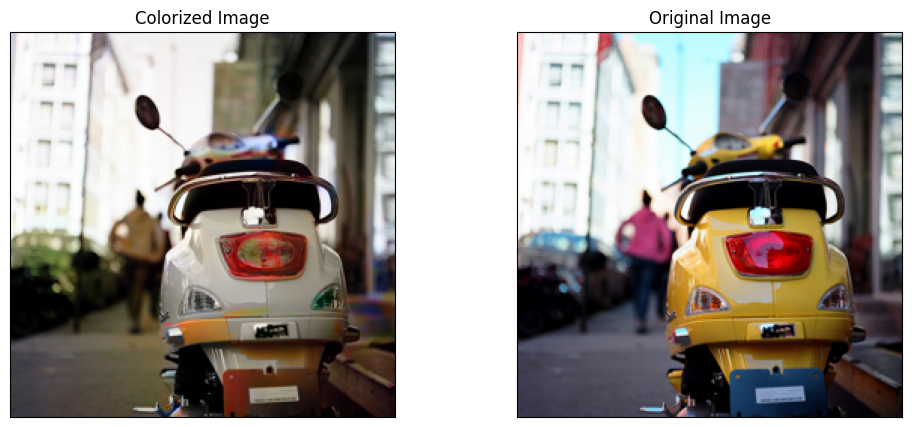

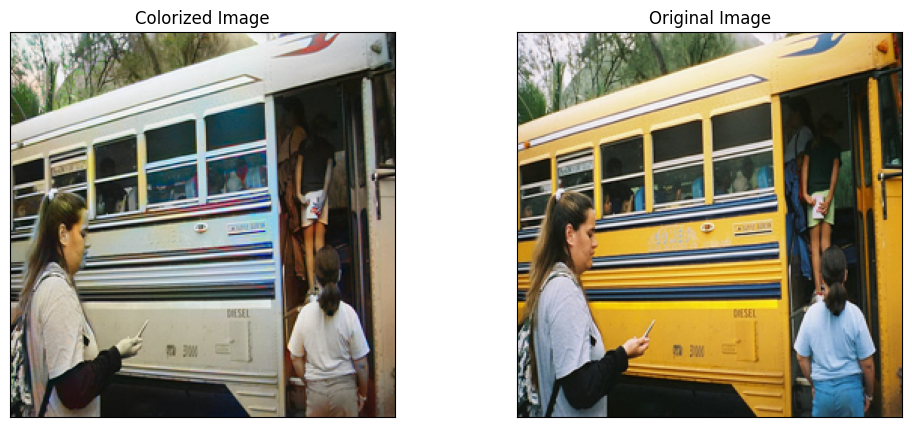

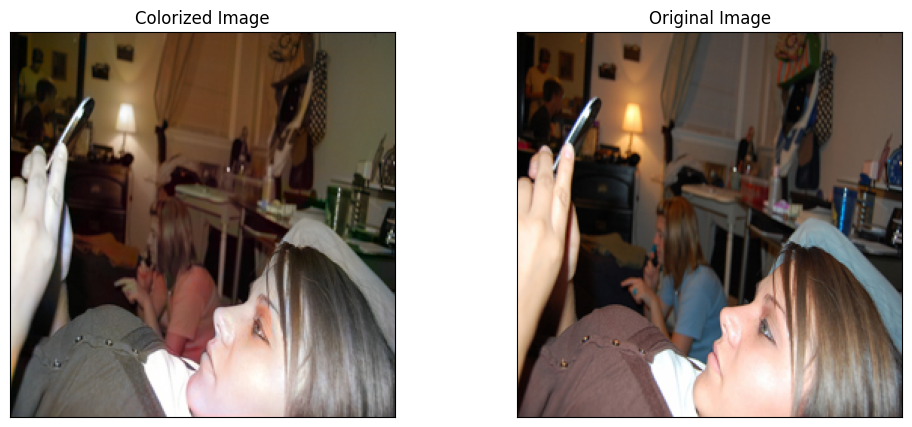

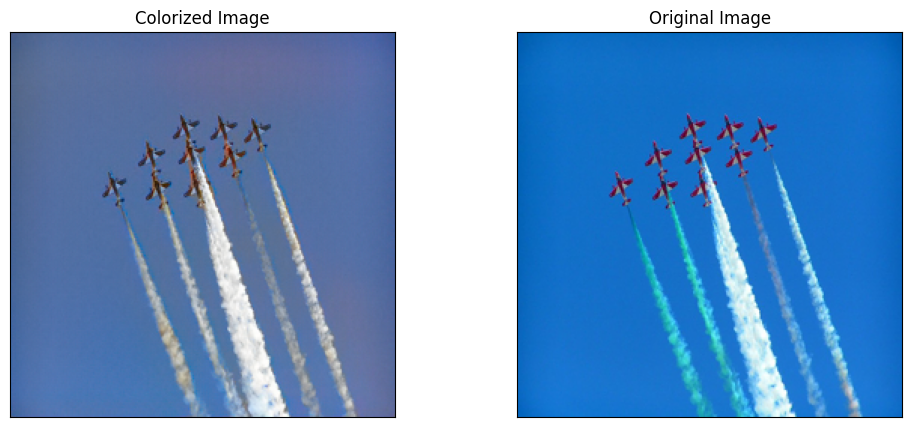

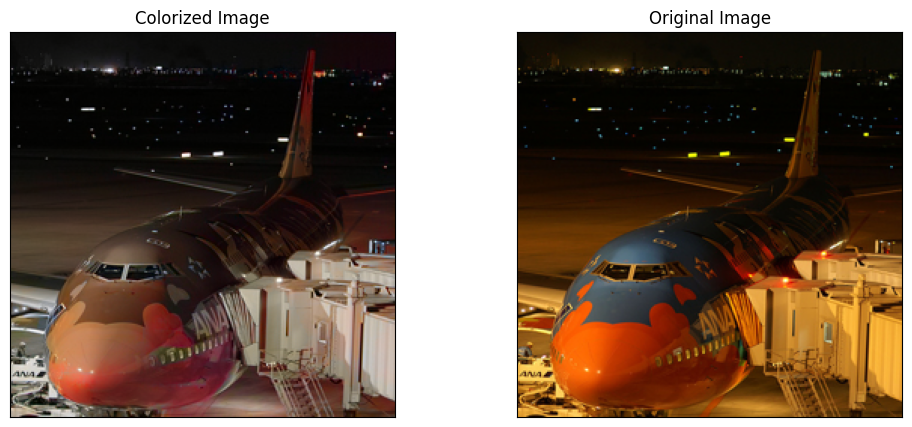

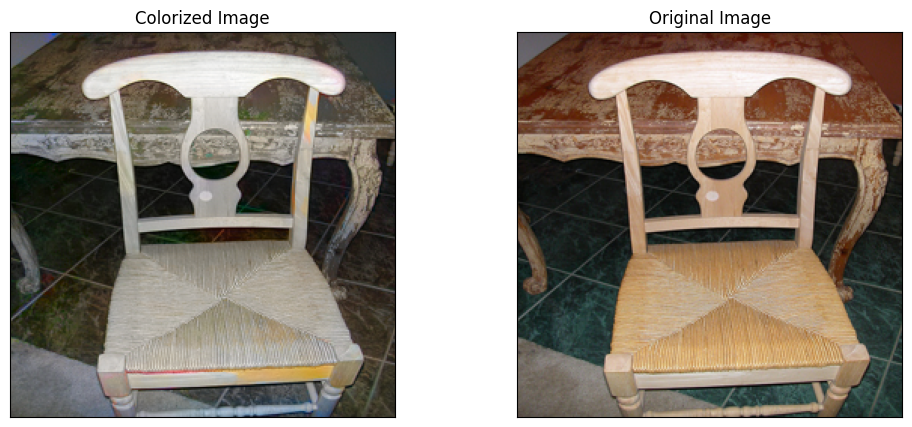

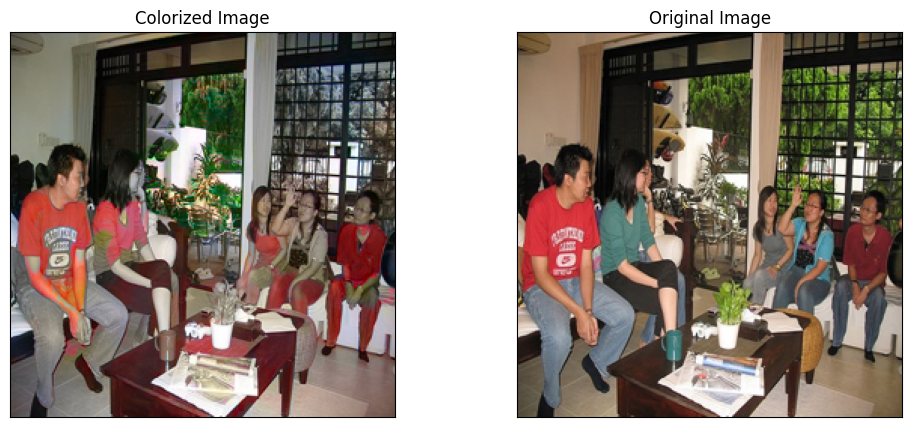

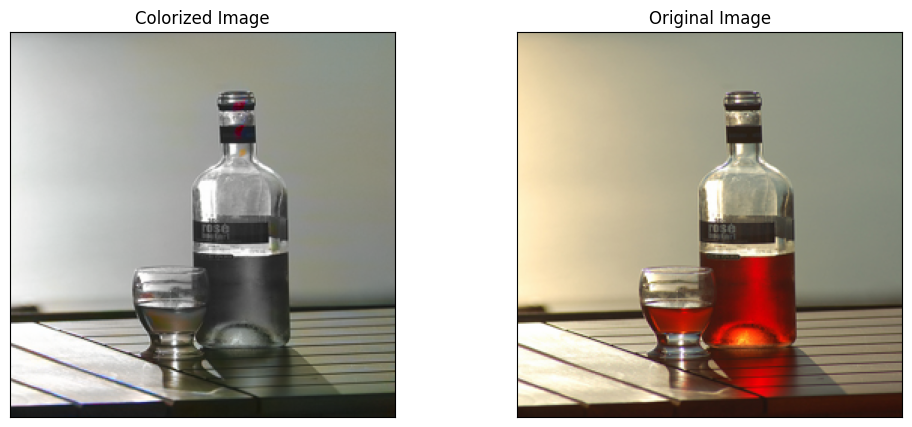

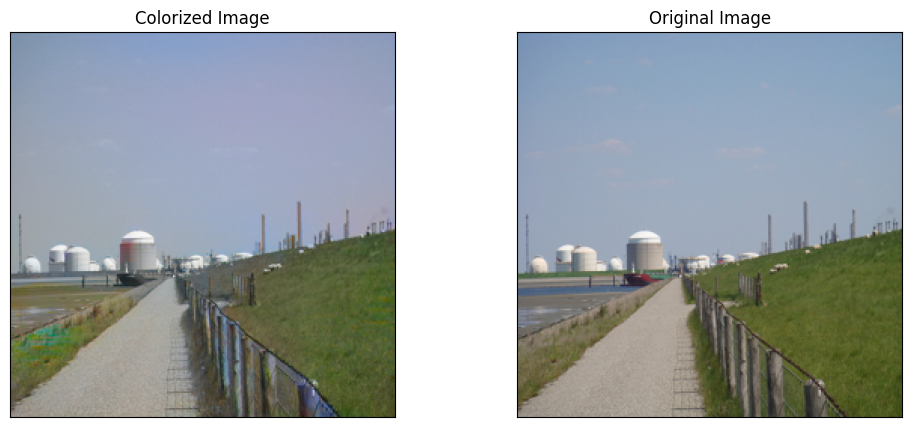

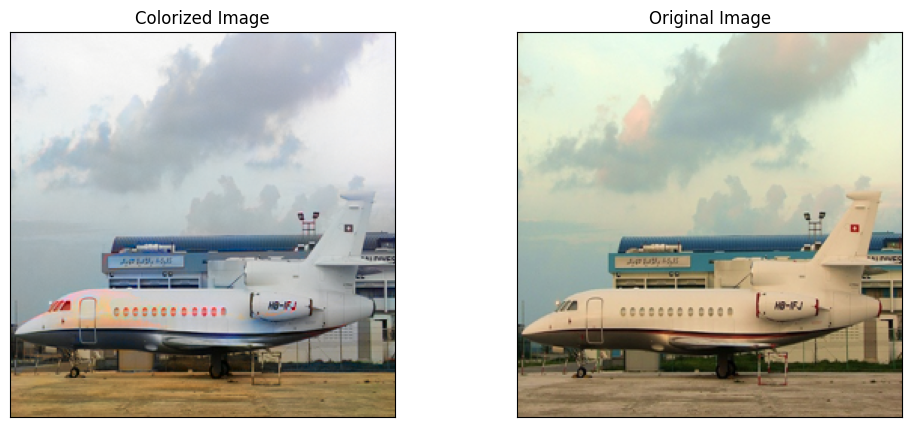

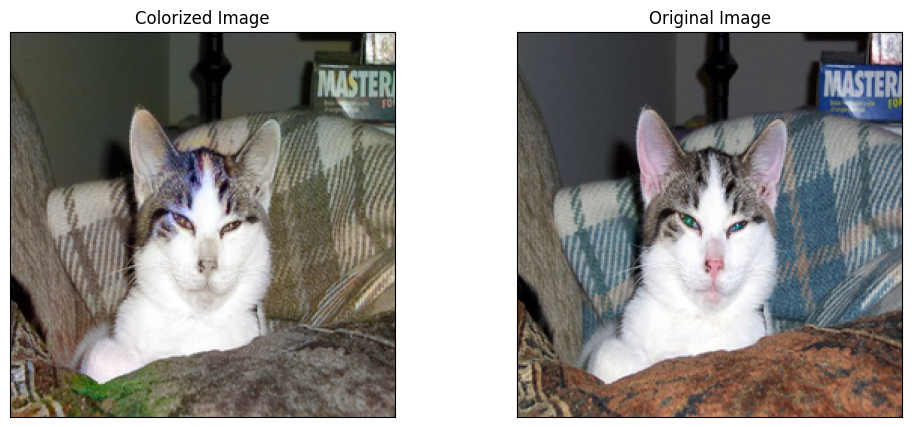

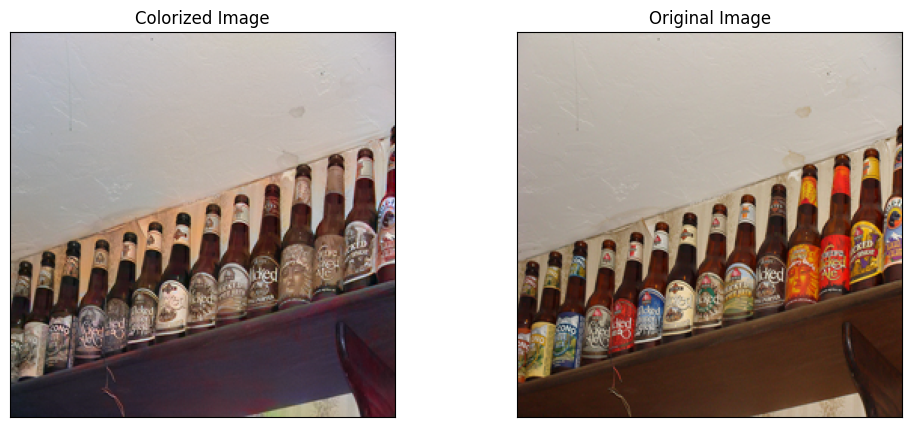

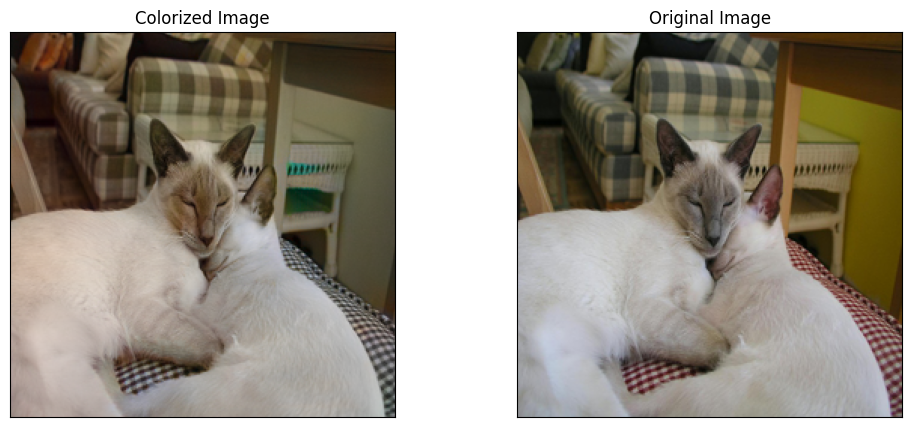

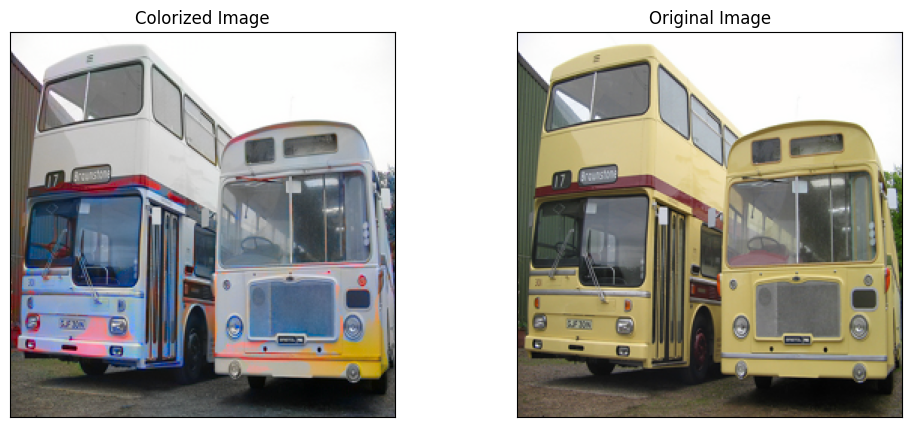

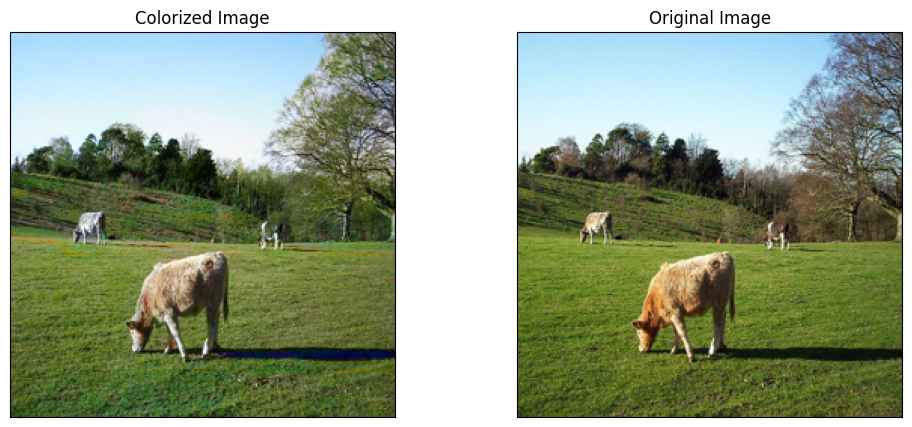

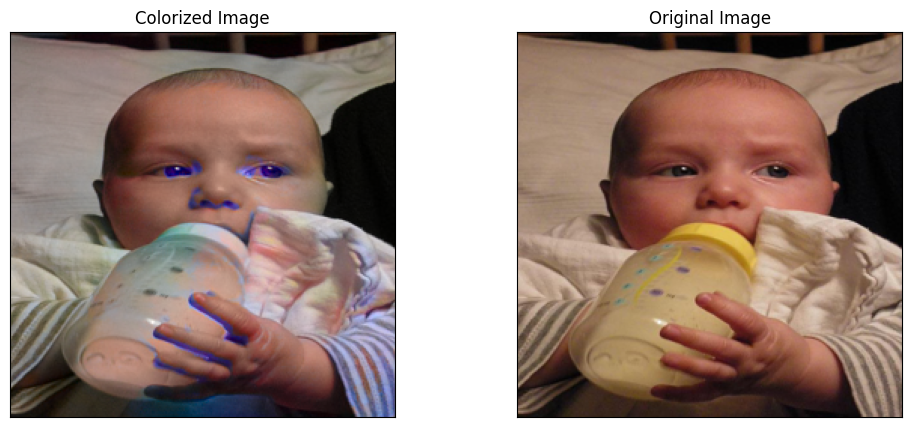

In [39]:
iter_num = 1
test_dl = make_dataloaders(paths=val_paths, split='val')
for i in range(iter_num):
    data = next(iter(test_dl))
    fake_imgs, real_imgs = predict(model, data)
    for generated_img, original_img in zip(fake_imgs, real_imgs):
        visualize(
            colorized_image = generated_img,
            original_image = original_img,
        )